# Aircraft Safety Analysis for Business Expansion

<img src="images/Flight-Safety-Instructions.jpg">

[Credit: Paxes.com](https://www.paxes.com/blog/flight-safety-instructions/)

## Business Understanding

My company has decided to expand into operating airplanes for commercial and private use. I have been tasked with examining the risks of different aircraft makes and models and making recommendations for the lowest-risk aircraft for purchase.

I will aim to identify which aircraft models present the lowest risk in terms of safety. The key questions I'm seeking to answer include:
- Which aircraft models have the lowest occurrences of severe injuries from high-damage events?
- How do factors such as the number of engines and the purpose of flight impact the safety of the aircraft?

## Data Understanding

The dataset contains records of aircraft incidents and accidents from the NTSB up to 2023, including information on the event, location, aircraft characteristics, and injury severity. The dataset has 90,348 entries and 31 columns. Some key columns include:

- `Event.Id`: Unique identifier for each event.
- `Event.Date`: Date of the event.
- `Location`: Location of the event.
- `Country`: Country where the event occurred.
- `Injury.Severity`: Severity of injuries in the event.
- `Aircraft.damage`: Extent of damage to the aircraft.
- `Make` and `Model`: Manufacturer and model of the aircraft.
- `Number.of.Engines`: Number of engines on the aircraft.
- `Purpose.of.flight`: The purpose of the flight during the event.

There are 5 numerical columns and 26 categorical columns. Examples of numerical columns include `Number.of.Engines`, `Total.Fatal.Injuries`, `Total.Serious.Injuries`, `Total.Minor.Injuries`, and `Total.Uninjured`. Examples of categorical columns include `Event.Id`, `Investigation.Type`, `Accident.Number`, `Event.Date`, and `Location`.

# Limitations

- The dataset only contains information about flights that have gone wrong and does not include information about general safety, flight hours, maintenance, and successful flights. This presents an incomplete picture when attempting to determine overall aircraft safety.

# Data Preparation

In this section, I will import our needed libraries for our notebook, import the data from a csv file, and begin cleaning and preparing the data for analysis using the following techniques:

1. **Handling Duplicate Values**: Identify and remove duplicate rows.
2. **Handling Unnecessary Values**: Identify and remove both columns and rows that are unnecessary to the analysis.
3. **Handling Missing Values**: Identify and handle missing values appropriately, either by imputation, placeholders, or removal.
4. **Data Type Conversion**: Convert columns to appropriate data types (e.g., dates to datetime objects, numerical columns to numeric types).
5. **Feature Engineering**: Create new features through encoding categorical values into numerical values such as `Aircraft.Damage` and extract useful information for analysis such as the month and year from `Event.Date`.

In [625]:
# Importing necessary libraries
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import helper_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [626]:
# Reading data from a CSV file
df = pd.read_csv('data/Aviation_Data.csv')

# Preview the data
df.head()

/var/folders/qs/svfy8y496zs3ryjhvjm063340000gn/T/ipykernel_15373/3991686835.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Aviation_Data.csv')


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [627]:
# Get an overview of the types of data, features, and completeness of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

In [628]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

# Resetting the index
df = df.reset_index(drop=True)

# Re-check the overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88958 entries, 0 to 88957
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88958 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

Removed 1390 duplicated rows.

In [629]:
# Function to display missing data for each column in numerical and percentage format
def percent_data_missing(df):
    # Summing the null values for each column
    missing_data_summary = df.isnull().sum().sort_values(ascending=False)
    # Converting to a percentage format
    missing_data_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

    # Creating the DataFrame
    missing_data_df = pd.DataFrame({'Missing Values': missing_data_summary, 'Percentage': missing_data_percentage})

    # Calculate total missing values
    total_missing = df.isnull().sum().sum()

    # Display info to the user
    print(missing_data_df)
    print(f'\nTotal Missing Values: {total_missing}')

In [630]:
percent_data_missing(df)

                        Missing Values  Percentage
Schedule                         76376   85.856247
Air.carrier                      72310   81.285550
FAR.Description                  56935   64.002113
Aircraft.Category                56671   63.705344
Longitude                        54585   61.360417
Latitude                         54576   61.350300
Airport.Code                     38826   43.645316
Airport.Name                     36254   40.754064
Broad.phase.of.flight            27234   30.614447
Publication.Date                 15299   17.198004
Total.Serious.Injuries           12579   14.140381
Total.Minor.Injuries             12002   13.491760
Total.Fatal.Injuries             11470   12.893725
Engine.Type                       7165    8.054363
Report.Status                     6453    7.253985
Purpose.of.flight                 6261    7.038153
Number.of.Engines                 6153    6.916747
Total.Uninjured                   5981    6.723398
Weather.Condition              

`Aircraft.Category` is something I'd like to be able to filter on and there are a ton of missing values. I want to see if we can glean that information from matching values in other columns. This is a great case for a function as we can probably use it for filling in other missing values later on.

In [631]:
# Function that searches a user-specified column to fill null values on in a provided dataframe,
# and a column to reference and find correct values to change nulls into.
def fill_nan_column_with_mode(df, column_to_fill, reference_column):
    nan_indices = df[df[column_to_fill].isna()].index.tolist()
    
    # Use tqdm to create a progress bar
    for index in tqdm(nan_indices, desc=f"Filling NaN values in '{column_to_fill}'"):
        row = df.loc[index]
        ref_value = row[reference_column]
        
        # If reference value is NaN, skip this row
        if pd.isna(ref_value):
            continue
        
        # Create a temporary DataFrame with the same reference value
        temp_df = df[df[reference_column] == ref_value]
        
        # Drop rows where the column to fill is NaN
        temp_df = temp_df.dropna(subset=[column_to_fill])
        
        # If temp_df is not empty, calculate the mode
        if not temp_df.empty:
            mode_value = temp_df[column_to_fill].mode()
            
            if not mode_value.empty:
                # Fill the NaN value with the mode
                df.at[index, column_to_fill] = mode_value.iloc[0]
                
    return df

In [632]:
# Checking for Aircraft.Category values in same Model
df = fill_nan_column_with_mode(df, 'Aircraft.Category', 'Model')

Filling NaN values in 'Aircraft.Category': 100%|██████████| 56671/56671 [03:02<00:00, 309.88it/s]


That saved 48,323 data points in the `Aircraft.Category` column.

Now let's get rid of any unncessary rows and columns

In [633]:
# Taking a look at the various aircraft categories
df['Aircraft.Category'].value_counts()

Aircraft.Category
Airplane             70768
Helicopter            7646
Glider                 989
Balloon                470
Gyrocraft              266
Weight-Shift           165
Powered Parachute       95
Ultralight              33
Unknown                 15
WSFT                     9
Blimp                    7
Powered-Lift             6
UNK                      2
Rocket                   1
ULTR                     1
Name: count, dtype: int64

In [634]:
# For now, I'm only wanting to keep Aircraft.Category values of 'Airplane', and 'Helicopter'
aircraft_cats_to_keep = ['Airplane', 'Helicopter']

# Drop all other categories
df = df[df['Aircraft.Category'].isin(aircraft_cats_to_keep)]

In [635]:
# `Schedule`, `Air.Carrier`, `FAR.Description`, `Latitude`, and `Longitude` all have missing data from over 60% of the rows.
# `Registration.Number`, `Airport.Name`, `Airport.Code`, and `Report.Status` cannot be imputed and is not helpful to the analysis.
# Dropping those columns
df.drop(columns=['Schedule', 'Air.carrier', 'FAR.Description', 'Latitude', 'Longitude', 'Registration.Number', 'Airport.Name', 'Airport.Code', 'Report.Status'], inplace=True)

In [636]:
# Dropping rows with <1% of missing values

# Attempting to impute Make from Model
df = fill_nan_column_with_mode(df, 'Model', 'Make')

# Dropping remaining rows with <1% missing values
df.dropna(subset=['Event.Id', 'Accident.Number', 'Event.Date', 'Location', 'Amateur.Built', 'Country', 'Make', 'Model'], inplace=True)

Filling NaN values in 'Model': 100%|██████████| 33/33 [00:00<00:00, 334.48it/s]


In [637]:
# Investigating makeup of amateur built aircraft
df['Amateur.Built'].value_counts()

Amateur.Built
No     72394
Yes     5692
Name: count, dtype: int64

In [638]:
# Dropping all amateur built aircraft
df = df[df['Amateur.Built'] != 'Yes']
# Dropping the `Amateur.Built` column
df.drop(columns=['Amateur.Built'], inplace=True)

`Injury.Severity` might be something that could help us with our safety determinations:

In [639]:
# Investigating `Injury.Severity`
df['Injury.Severity'].unique()

array(['Fatal(2)', 'Fatal(3)', 'Fatal(1)', 'Non-Fatal', 'Fatal(4)',
       'Incident', 'Fatal(8)', 'Fatal(78)', 'Fatal(7)', 'Fatal(6)',
       'Fatal(5)', 'Fatal(12)', 'Fatal(14)', 'Fatal(10)', 'Fatal(11)',
       'Fatal(17)', 'Fatal(13)', 'Fatal(29)', 'Fatal(9)', 'Unavailable',
       'Fatal(135)', 'Fatal(25)', 'Fatal(82)', 'Fatal(156)', 'Fatal(18)',
       'Fatal(144)', 'Fatal(111)', 'Fatal(20)', 'Fatal(73)', 'Fatal(27)',
       'Fatal(34)', 'Fatal(87)', 'Fatal(16)', 'Fatal(56)', 'Fatal(37)',
       'Fatal(54)', 'Fatal(65)', 'Fatal(160)', 'Fatal(189)', 'Fatal(97)',
       'Fatal(125)', 'Fatal(228)', 'Fatal(52)', 'Fatal(15)', 'Fatal(229)',
       'Fatal(80)', 'Fatal(169)', 'Fatal(88)', 'Fatal(131)', 'Fatal(60)',
       'Fatal(143)', 'Fatal(83)', 'Fatal(24)', 'Fatal(44)', 'Fatal(64)',
       'Fatal(92)', 'Fatal(19)', 'Fatal(26)', 'Fatal(138)', 'Fatal(206)',
       'Fatal(71)', 'Fatal(23)', 'Fatal(21)', 'Fatal(115)', 'Fatal(141)',
       'Fatal(121)', 'Fatal(45)', 'Fatal(145)', 'Fatal(1

There are a lot of different variations of "Fatal" in this column. All with numbers in parentheses following the value. Let's compare these to a sample of the `Total.Fatal.Injuries` column.

In [640]:
# Comparing `Injury.Severity` column to `Total.Fatal.Injuries` column
df[df['Injury.Severity'] == 'Fatal(2)']['Total.Fatal.Injuries']

0        2.0
3        2.0
15       2.0
24       2.0
33       2.0
        ... 
63822    2.0
63823    2.0
63826    2.0
63828    2.0
63874    2.0
Name: Total.Fatal.Injuries, Length: 2972, dtype: float64

In [641]:
# Unique values of `Injury.Severity` appear to be duplicated in other columns.
# Dropping `Injury.Severity` column.
df.drop(columns=['Injury.Severity'], inplace=True)

In [642]:
# There are two 'date' columns, and I am only interested in the date of the event.
# Dropping `Publication.Date` column
df.drop(columns=['Publication.Date'], inplace=True)

In [643]:
# Converting `Event.Date` into a datetime object
df['Event.Date'] = pd.to_datetime(df['Event.Date'])

In [644]:
# Moving onto `Weather.Conditions`
df['Weather.Condition'].unique()

array(['UNK', 'IMC', 'VMC', nan, 'Unk'], dtype=object)

In [645]:
# Filling null values with 'UNK'
df['Weather.Condition'] = df['Weather.Condition'].fillna('UNK')

In [646]:
# Function to rename column values (case-insensitive)
def rename_value(df, col_name, old_value, new_value):
    # Setting old value to new value
    df.loc[df[col_name].str.lower().str.contains(old_value.lower()), col_name] = new_value

rename_value(df, 'Weather.Condition', 'Unk', 'UNK')

df['Weather.Condition'].unique()

array(['UNK', 'IMC', 'VMC'], dtype=object)

In [647]:
# Investigating the `Broad.phase.of.flight` column
df['Broad.phase.of.flight'].unique()

array(['Cruise', 'Approach', 'Climb', 'Unknown', 'Takeoff', 'Landing',
       'Taxi', 'Descent', 'Maneuvering', 'Standing', 'Go-around', 'Other',
       nan], dtype=object)

In [648]:
# Filling null values with 'Unknown'
df['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')

In [649]:
# Investigating `Purpose.of.flight` column
df['Purpose.of.flight'].unique()

array(['Personal', nan, 'Business', 'Instructional', 'Unknown', 'Ferry',
       'Executive/corporate', 'Aerial Observation', 'Aerial Application',
       'Public Aircraft', 'Skydiving', 'Other Work Use', 'Positioning',
       'Flight Test', 'Air Race/show', 'Air Drop',
       'Public Aircraft - Federal', 'Glider Tow',
       'Public Aircraft - Local', 'External Load',
       'Public Aircraft - State', 'Banner Tow', 'Firefighting',
       'Air Race show', 'PUBS', 'ASHO', 'PUBL'], dtype=object)

In [650]:
# Filling null values with 'Unknown'
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna('Unknown')

In [651]:
# There are some flight types in here that likely don't apply to our business case so let's drop them
# List of flight types to drop
flight_types_to_drop = ['Air Drop', 'Air Race/show', 'Firefighting', 'Glider Tow', 'Air Race show', 'Flight Test']

# Drop the unwanted flight types
df = df[~df['Purpose.of.flight'].isin(flight_types_to_drop)]

In [652]:
# Attempting to fill missing `Number.of.Engines` values with other `Model` matches then dropping the remaining null values.
df = fill_nan_column_with_mode(df, 'Number.of.Engines', 'Model')

df = df.dropna(subset=['Number.of.Engines'])

Filling NaN values in 'Number.of.Engines': 100%|██████████| 4404/4404 [00:11<00:00, 376.86it/s]


In [653]:
# Attempting to fill missing `Engine.Type` values with other `Model` matches then filling null values with 'UNK'
df = fill_nan_column_with_mode(df, 'Engine.Type', 'Model')

df['Engine.Type'] = df['Engine.Type'].fillna('UNK')

Filling NaN values in 'Engine.Type': 100%|██████████| 5219/5219 [00:14<00:00, 370.51it/s]


In [654]:
# Filling null `Aircraft.Damage` values with 'Unknown`
df['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')

In [655]:
# I want to see how many rows have zero values for all injury and uninjured columns
# Specify the columns to check
columns_to_check = ['Total.Uninjured', 'Total.Minor.Injuries', 'Total.Serious.Injuries', 'Total.Fatal.Injuries']

# Count rows where all specified columns are NaN
num_rows_all_nan = df[columns_to_check].isna().all(axis=1).sum()

print(f"Number of rows with NaN in all specified columns: {num_rows_all_nan}")

Number of rows with NaN in all specified columns: 116


In [656]:
# There aren't many rows that meet these criteria, so I will drop them
# Identify rows where all specified columns are NaN
rows_to_drop = df[columns_to_check].isna().all(axis=1)

# Drop those rows
df = df.drop(index=df[rows_to_drop].index)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [657]:
# Filling the missing values in the 'injury' columns with 0
columns_to_fill = ['Total.Uninjured', 'Total.Minor.Injuries', 'Total.Serious.Injuries', 'Total.Fatal.Injuries']

for col in columns_to_fill:
    df[col] = df[col].fillna(0)

In [658]:
# Investigating the `Country` values
df['Country'].value_counts()

Country
United States               66323
Brazil                        332
Mexico                        306
Canada                        286
United Kingdom                262
                            ...  
French Guiana                   1
Chad                            1
Cayenne                         1
Yemen                           1
Turks and Caicos Islands        1
Name: count, Length: 204, dtype: int64

In [659]:
# Vast majority of incidents are in North America, so I'll drop everything else
# List of flight types to drop
countries_to_keep = ['Canada', 'United States', 'Mexico']

# Drop the unwanted flight types
df = df[df['Country'].isin(countries_to_keep)]

In [660]:
percent_data_missing(df)

                        Missing Values  Percentage
Event.Id                             0         0.0
Number.of.Engines                    0         0.0
Weather.Condition                    0         0.0
Total.Uninjured                      0         0.0
Total.Minor.Injuries                 0         0.0
Total.Serious.Injuries               0         0.0
Total.Fatal.Injuries                 0         0.0
Purpose.of.flight                    0         0.0
Engine.Type                          0         0.0
Model                                0         0.0
Investigation.Type                   0         0.0
Make                                 0         0.0
Aircraft.Category                    0         0.0
Aircraft.damage                      0         0.0
Country                              0         0.0
Location                             0         0.0
Event.Date                           0         0.0
Accident.Number                      0         0.0
Broad.phase.of.flight          

In [661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66915 entries, 0 to 71449
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                66915 non-null  object        
 1   Investigation.Type      66915 non-null  object        
 2   Accident.Number         66915 non-null  object        
 3   Event.Date              66915 non-null  datetime64[ns]
 4   Location                66915 non-null  object        
 5   Country                 66915 non-null  object        
 6   Aircraft.damage         66915 non-null  object        
 7   Aircraft.Category       66915 non-null  object        
 8   Make                    66915 non-null  object        
 9   Model                   66915 non-null  object        
 10  Number.of.Engines       66915 non-null  float64       
 11  Engine.Type             66915 non-null  object        
 12  Purpose.of.flight       66915 non-null  object     

## Feature Engineering

In [662]:
# Create a total passengers column
df['Total.Pax'] = df['Total.Uninjured'] + df['Total.Minor.Injuries'] + df ['Total.Serious.Injuries'] + df['Total.Fatal.Injuries']

In [663]:
# Create a year column
df['Event.Year'] = df['Event.Date'].dt.year

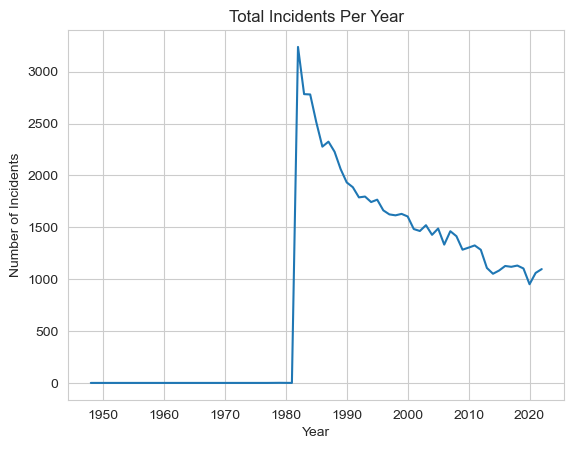

In [664]:
# How is the data spread over time?
yearly_data = df['Event.Year'].value_counts().sort_index()

fig, ax = plt.subplots()

yearly_data.plot(kind='line', ax=ax)

ax.set_title("Total Incidents Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Incidents")

plt.show()

In [665]:
# Virtually no data prior to 1982, we'll set our range to that.
df = df[df['Event.Year'] >= 1982]

In [666]:
# Convert all values in the 'Make' column to title case
df['Make'] = df['Make'].str.title()

After some research, a list of popular aircraft manufacturers has been populated. More on this in the following section.

In [667]:
# List of private and commercial aircraft manufacturers
private_craft = ['Bombardier', 'Beechcraft', 'Cessna', 'Dassault', 'Gulfstream', 'Pilatus', 'Embraer']
commercial_craft = ['Boeing', 'Airbus', 'Mitsubishi', 'Embraer']
helicopter_craft = ['Bell', 'Robinson']

def determine_market(row):
    make = row['Make']
    model = row['Model']

    # Embraer has both private and commercial aircraft in the lists
    if make == 'Embraer':
        if 'ERJ' in model:
            return 'Commercial'
        elif 'EMB' in model:
            return 'Private'

    # Check for private and commercial crafts
    if make in private_craft:
        return 'Private'
    elif make in commercial_craft:
        return 'Commercial'
    elif make in helicopter_craft:
        return 'Helicopter'

    return 'Other'

# Function to consolidate various string formats of the same makes
def format_make(row):
    make = row['Make']

    for craft_list in [private_craft, commercial_craft, helicopter_craft]:
        for formatted_make in craft_list:
            if formatted_make.lower() in make.lower():
                return formatted_make
    return 'Other'

# Apply the function to create the 'Market' column
df['Market'] = df.apply(determine_market, axis=1)

# Apply the function to create the 'make.formatted' column
df['make.formatted'] = df.apply(format_make, axis=1)

In [668]:
# Calculating our safety metric 'Fatality Rate' which is total fatal injuries divided by total passengers
df['Fatality.Rate'] = df['Total.Fatal.Injuries'] / df['Total.Pax'] * 100

In [669]:
# Encode damage severity
def damage_encode(row):
    if row['Aircraft.damage'] == 'Minor':
        return 1
    elif row['Aircraft.damage'] == 'Substantial':
        return 2
    elif row['Aircraft.damage'] == 'Destroyed':
        return 3
    else:
        return 0
    
    
df['Damage.Encoded'] = df.apply(damage_encode, axis=1)

In [670]:
# Consolidate various versions of models into a regular format
df['model.formatted'] = df.apply(helper_functions.update_model, axis=1)

# Data Analysis

[According to Assets America, the top 10 commercial aircraft manufacturers are:](https://assetsamerica.com/aircraft-manufacturers/)
- Boeing 
- Airbus
- Embraer
- Bombardier
- Comac (Russian company not operated in NA)
- Mitsubishi
- UAC (Russian company not operated in NA)
- Aviastar-SP (Russian company not operated in NA)
- Kazan Aircraft Production Association (Russian company not operated in NA)
- GippsAero (Australian company not operated in NA)

The top 10 private aircraft manufacturers are:
- Airbus Corporate Jets
- Boeing Business Jet
- Bombardier Business Aircraft
- Beechcraft
- Cessna
- Dassault Aviation
- Embraer
- Gulfstream Aerospace
- Pilatus Business Aircraft
- Hawker

[According to General Aviation News, the top helicopter manufacturers are:](https://generalaviationnews.com/2023/03/16/top-10-best-selling-rotorcraft-in-2022/)
- Airbus
- Bell
- Cabri
- Robinson

## Goal

My goal is to make safety recommendations for each category (Commercial, Private, and Helicopter) by identifying the safest aircraft characteristics based on the analysis of incident data. From there, we can begin to investigate specific models.

The key questions I aim to answer are:

- What correlations exist between features?
- How do factors such as the number of engines and engine type the safety of the aircraft?

## Exclusions

Based on the dataset availability certain manufacturers will be excluded from the analysis:

- **Commercial Aircraft:** Comac, UAC, Aviastar-SP, Kazan, and GippsAero will not be uased as they do not operate in North America.
- **Private Aircraft:** Airbus Corporate Jets and Boeing Business Jets will not be used as they are not present in the dataset.
- **Helicopters:** Airbus and Cabri do not exist in the dataset and will not be used.

By focusing on the available manufacturers and data, I can provide a more accurate and data-driven recommendation for each category.

In [671]:
# Now that the cleaning process is nearly done, I'll create a copy to analyze
df_clean = df[(df['model.formatted'] != 'N/A') & (df['make.formatted'] != 'Other')]

In [672]:
df_clean.describe()

,Event.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Total.Pax,Event.Year,Fatality.Rate,Damage.Encoded
count,29473,29473.000000,29473.000000,29473.000000,29473.000000,29473.000000,29473.000000,29473.000000,29342.000000,29473.000000
mean,1997-12-30 12:50:15.044277888,1.125573,0.325077,0.214264,0.283039,4.963356,5.785736,1997.498422,13.724119,2.103518
min,1982-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1982.000000,0.000000,0.000000
25%,1987-11-24 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1987.000000,0.000000,2.000000
50%,1996-03-13 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1996.000000,0.000000,2.000000
75%,2006-07-19 00:00:00,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2006.000000,0.000000,2.000000
max,2022-12-26 00:00:00,4.000000,228.000000,137.000000,50.000000,588.000000,588.000000,2022.000000,100.000000,3.000000
std,NaN,0.369795,1.904767,1.494492,0.995185,26.013925,26.297615,11.465135,33.368615,0.544104


## Correlations

Looking at correlations in the overall, private, commercial, and helicopter datasets.

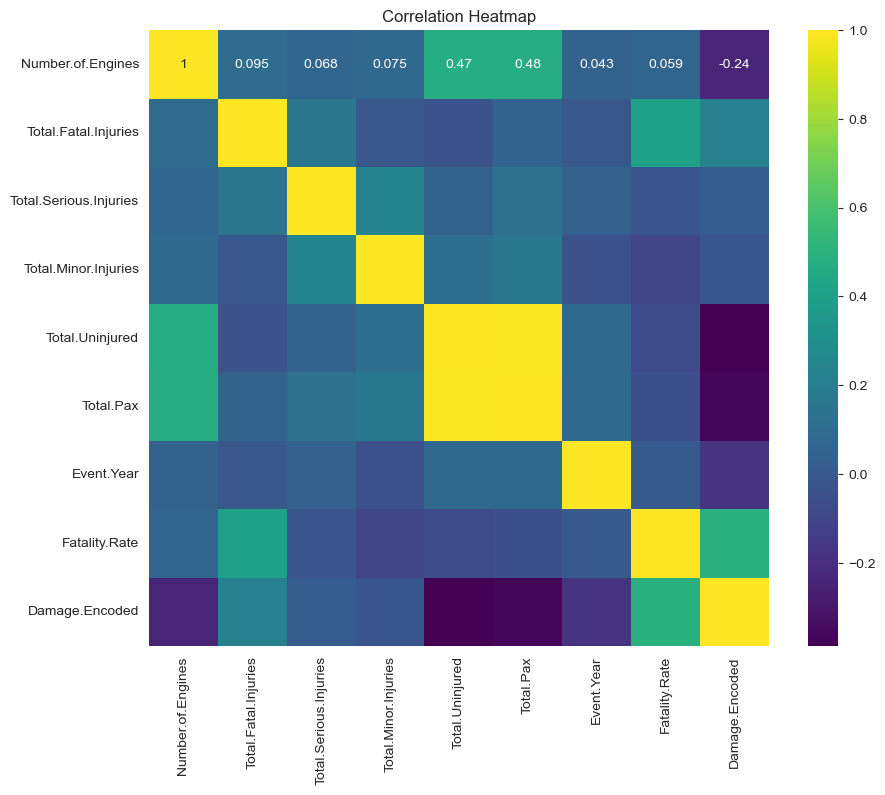

In [673]:
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate the correlation matrix and plot the heatmap
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='viridis', ax=ax).set_title("Correlation Heatmap")

# Show the plot
plt.show()

In [674]:
# Grouping the last 10 years of commercial, private, and helicopter data
df_private = df_clean[(df_clean['Market'] == 'Private')]
df_commercial = df_clean[(df_clean['Market'] == 'Commercial')]
df_helicopter = df_clean[(df_clean['Market'] == 'Helicopter')]

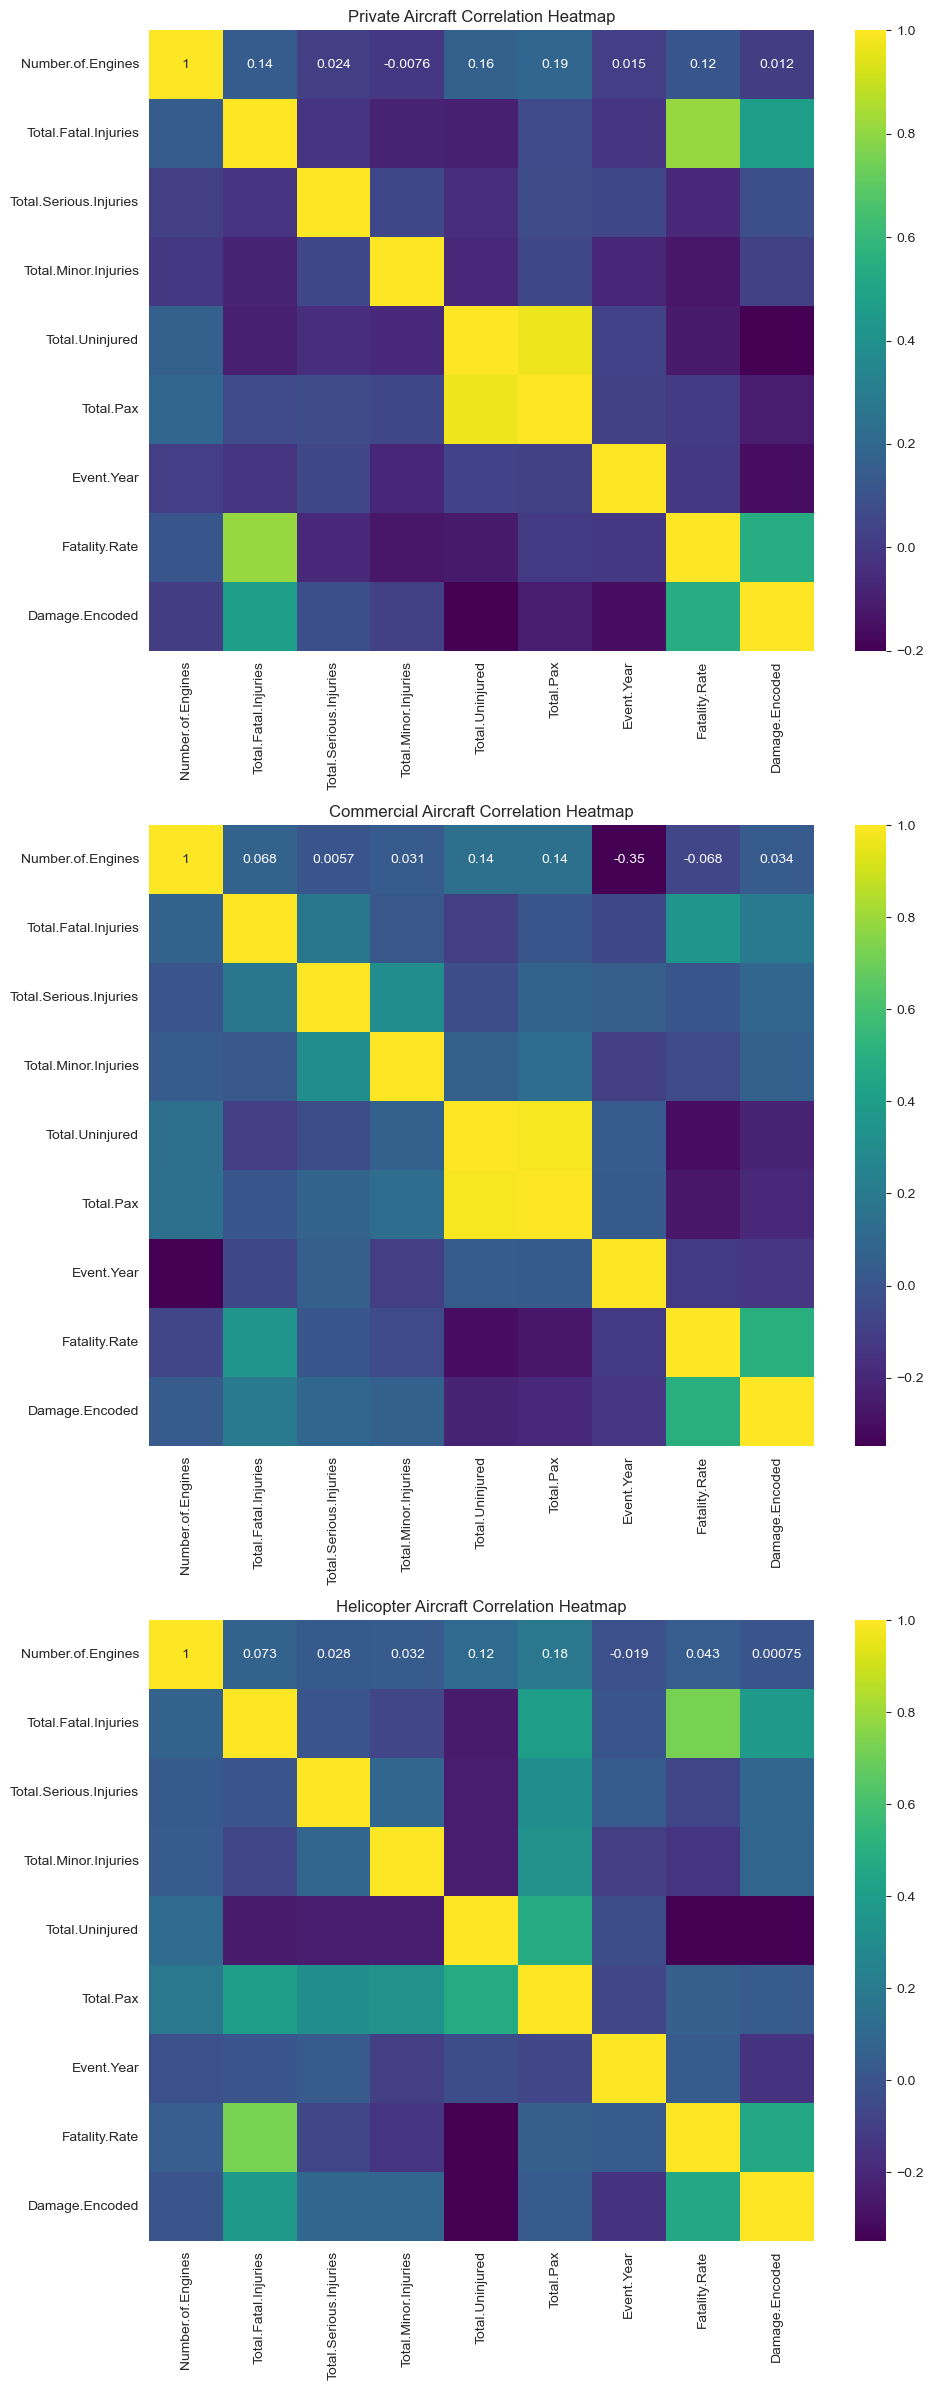

In [675]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 24))

# Calculate the correlation matrices
corr_private = df_private.corr(numeric_only=True)
corr_commercial = df_commercial.corr(numeric_only=True)
corr_helicopter = df_helicopter.corr(numeric_only=True)

# Plot the heatmap for private aircraft
sns.heatmap(corr_private, annot=True, cmap='viridis', ax=ax1)
ax1.set_title("Private Aircraft Correlation Heatmap")

# Plot the heatmap for commercial aircraft
sns.heatmap(corr_commercial, annot=True, cmap='viridis', ax=ax2)
ax2.set_title("Commercial Aircraft Correlation Heatmap")

# Plot the heatmap for helicopter aircraft
sns.heatmap(corr_helicopter, annot=True, cmap='viridis', ax=ax3)
ax3.set_title("Helicopter Aircraft Correlation Heatmap")

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()

## Engine Counts

Helicopters in this dataset have a single engine so for this, we will only look and private and commercial airplanes

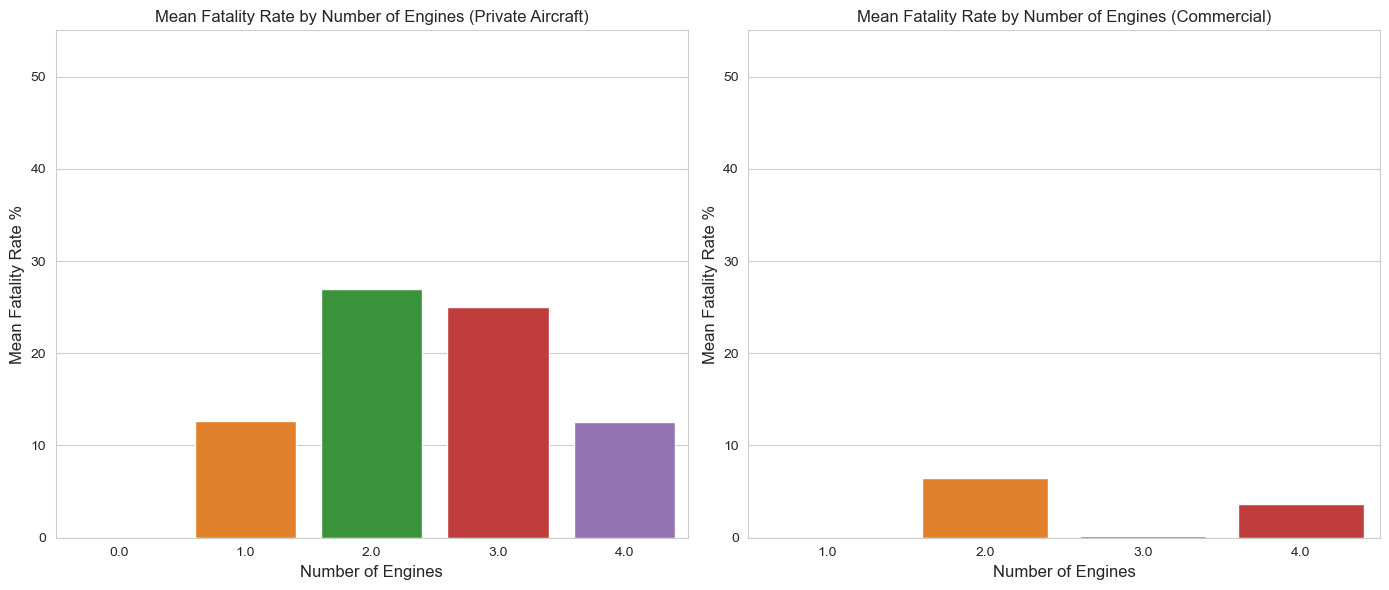

In [676]:
# Calculate the counts of each 'Number.of.Engines' and their corresponding mean fatality rates
private_engine_counts = df_private['Number.of.Engines'].value_counts().sort_index()
private_fatality_rates = df_private.groupby('Number.of.Engines')['Fatality.Rate'].mean().loc[private_engine_counts.index]

commercial_engine_counts = df_commercial['Number.of.Engines'].value_counts().sort_index()
commercial_fatality_rates = df_commercial.groupby('Number.of.Engines')['Fatality.Rate'].mean().loc[commercial_engine_counts.index]

# Convert counts and rates to a DataFrame for plotting
private_engine_df = pd.DataFrame({
    'Number_of_Engines': private_engine_counts.index,
    'Counts': private_engine_counts.values,
    'Fatality_Rate': private_fatality_rates.values
})

# Convert counts and rates to a DataFrame for plotting
commercial_engine_df = pd.DataFrame({
    'Number_of_Engines': commercial_engine_counts.index,
    'Counts': commercial_engine_counts.values,
    'Fatality_Rate': commercial_fatality_rates.values
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create bar plot
sns.barplot(x='Number_of_Engines', y='Fatality_Rate', data=private_engine_df, ax=ax1)

# Set plot labels and title
ax1.set_xlabel('Number of Engines', size=12)
ax1.set_ylabel('Mean Fatality Rate %', size=12)
ax1.set_title('Mean Fatality Rate by Number of Engines (Private Aircraft)')

# Create bar plot
sns.barplot(x='Number_of_Engines', y='Fatality_Rate', data=commercial_engine_df, ax=ax2)

# Set plot labels and title
ax2.set_xlabel('Number of Engines', size=12)
ax2.set_ylabel('Mean Fatality Rate %', size=12)
ax2.set_title('Mean Fatality Rate by Number of Engines (Commercial)')

ax1.set_ylim([0, 55])
ax2.set_ylim([0, 55])

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

## Damage Severity

Looking at the distribution of how well aircraft hold up.

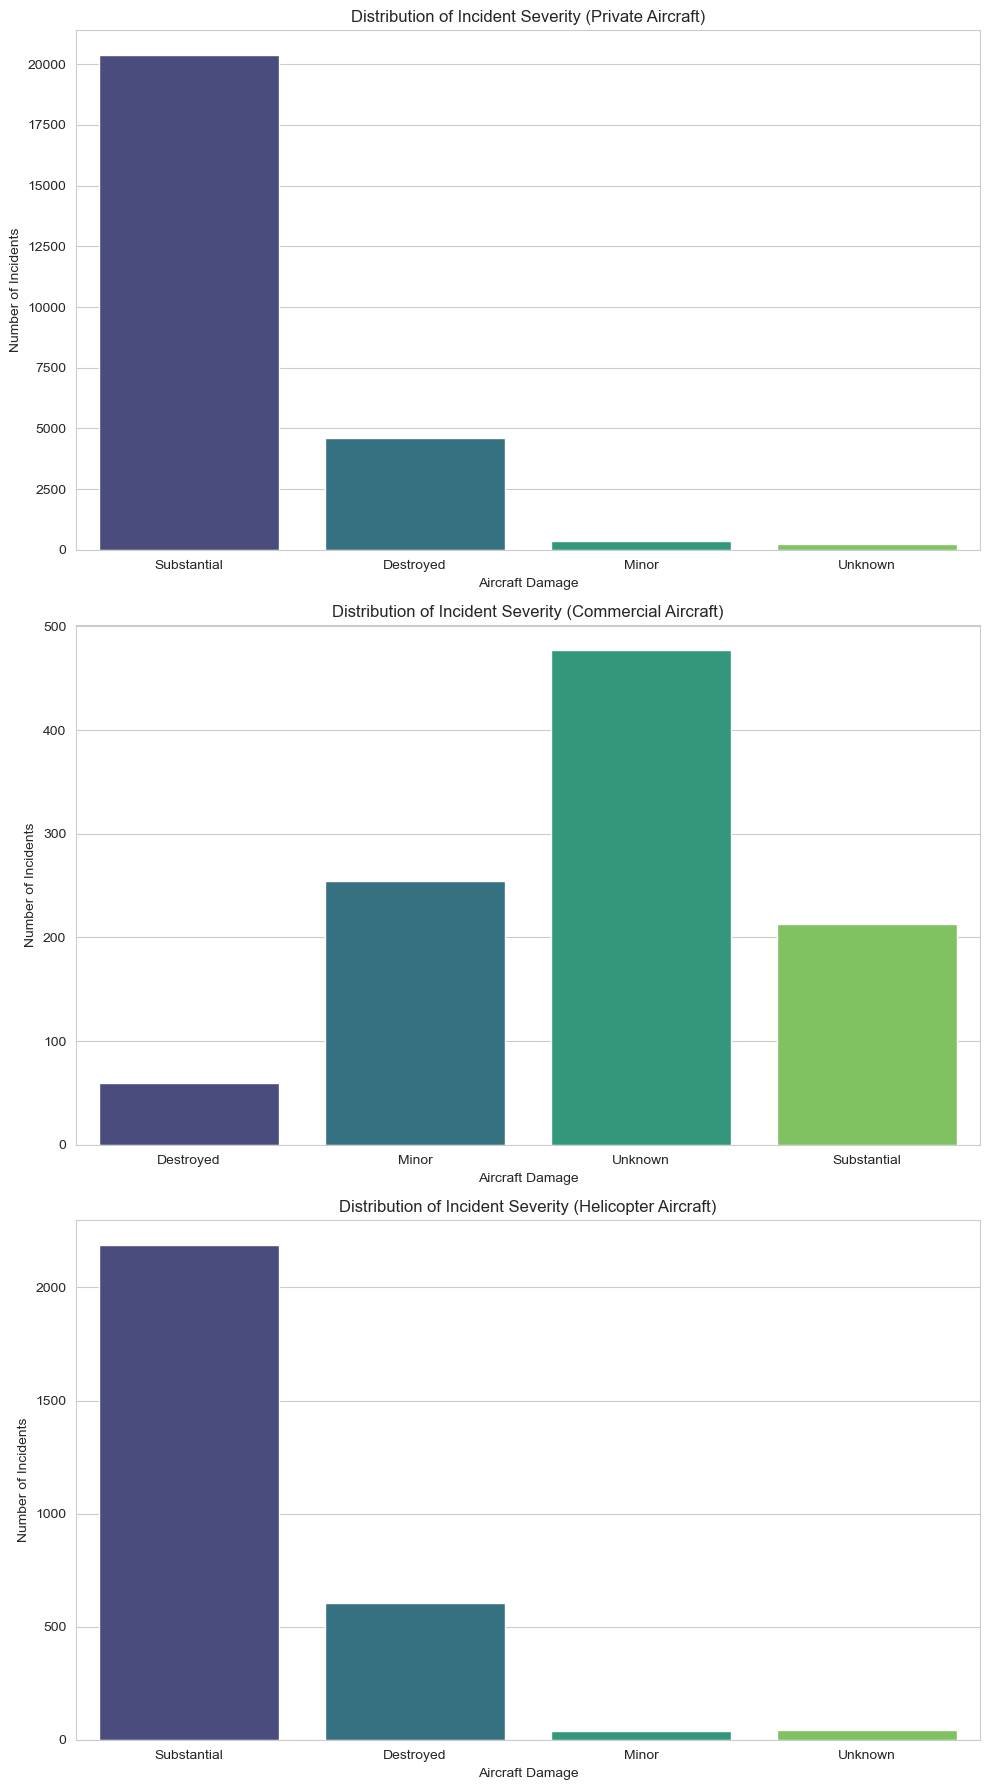

In [677]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

# Plot for df_private
sns.countplot(x='Aircraft.damage', data=df_private, palette='viridis', ax=ax1)
ax1.set_title('Distribution of Incident Severity (Private Aircraft)')
ax1.set_xlabel('Aircraft Damage')
ax1.set_ylabel('Number of Incidents')

# Plot for df_commercial
sns.countplot(x='Aircraft.damage', data=df_commercial, palette='viridis', ax=ax2)
ax2.set_title('Distribution of Incident Severity (Commercial Aircraft)')
ax2.set_xlabel('Aircraft Damage')
ax2.set_ylabel('Number of Incidents')

# Plot for df_helicopter
sns.countplot(x='Aircraft.damage', data=df_helicopter, palette='viridis', ax=ax3)
ax3.set_title('Distribution of Incident Severity (Helicopter Aircraft)')
ax3.set_xlabel('Aircraft Damage')
ax3.set_ylabel('Number of Incidents')

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()

## Engine Type

Investigating if there are trends of fatality rates in relation to the engine types.

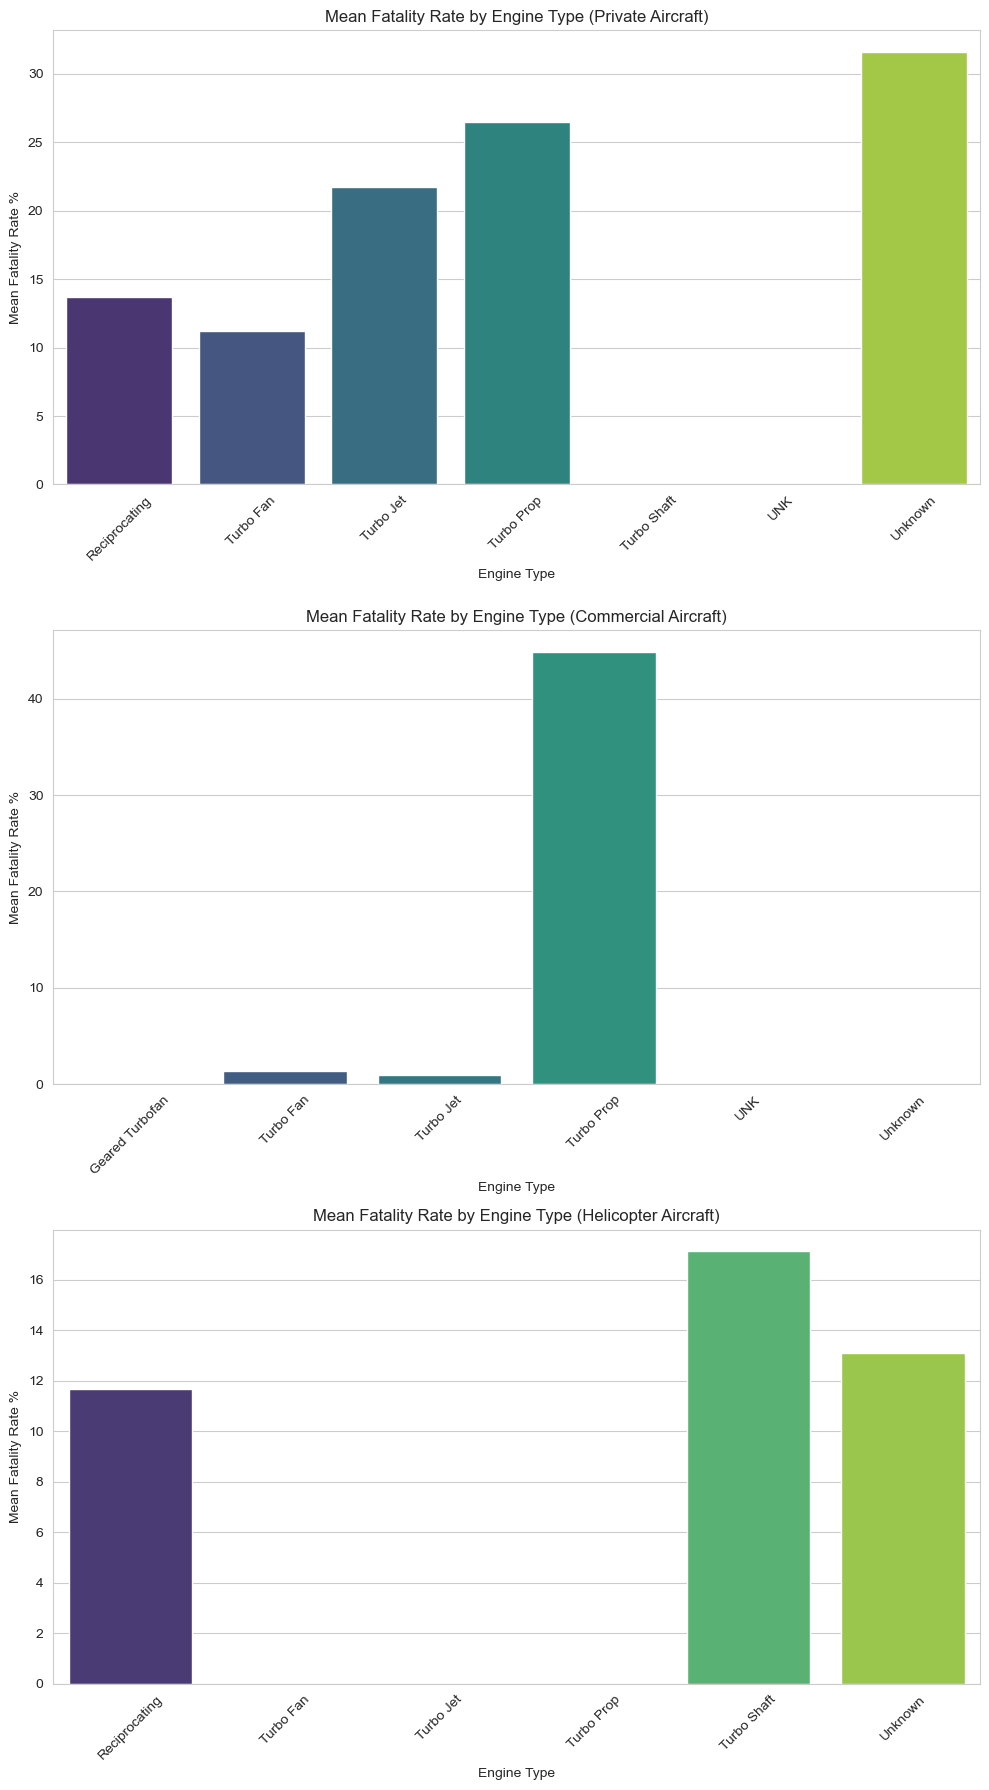

In [678]:
# Calculate the mean fatality rate by engine type for each dataframe
private_engine_fatality = df_private.groupby('Engine.Type')['Fatality.Rate'].mean().reset_index()
commercial_engine_fatality = df_commercial.groupby('Engine.Type')['Fatality.Rate'].mean().reset_index()
helicopter_engine_fatality = df_helicopter.groupby('Engine.Type')['Fatality.Rate'].mean().reset_index()

# Create a figure with 3 subplots arranged vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

# Plot for df_private
sns.barplot(x='Engine.Type', y='Fatality.Rate', data=private_engine_fatality, palette='viridis', ax=ax1)
ax1.set_title('Mean Fatality Rate by Engine Type (Private Aircraft)')
ax1.set_xlabel('Engine Type')
ax1.set_ylabel('Mean Fatality Rate %')
ax1.tick_params(axis='x', rotation=45)

# Plot for df_commercial
sns.barplot(x='Engine.Type', y='Fatality.Rate', data=commercial_engine_fatality, palette='viridis', ax=ax2)
ax2.set_title('Mean Fatality Rate by Engine Type (Commercial Aircraft)')
ax2.set_xlabel('Engine Type')
ax2.set_ylabel('Mean Fatality Rate %')
ax2.tick_params(axis='x', rotation=45)

# Plot for df_helicopter
sns.barplot(x='Engine.Type', y='Fatality.Rate', data=helicopter_engine_fatality, palette='viridis', ax=ax3)
ax3.set_title('Mean Fatality Rate by Engine Type (Helicopter Aircraft)')
ax3.set_xlabel('Engine Type')
ax3.set_ylabel('Mean Fatality Rate %')
ax3.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()

## Passenger Counts

Are there trends based on passenger capacity?

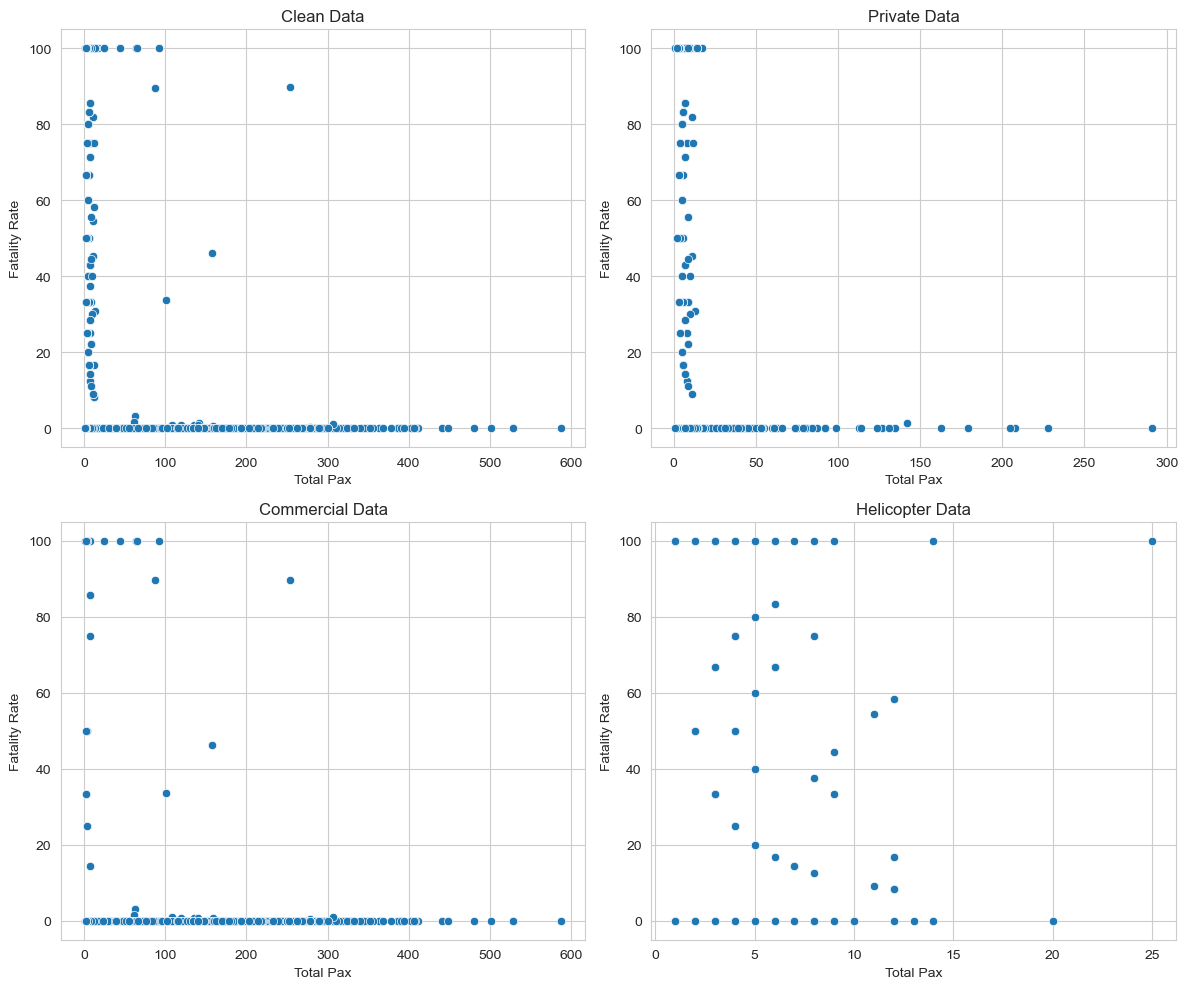

In [679]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for df_clean
sns.scatterplot(data=df_clean, x='Total.Pax', y='Fatality.Rate', ax=axs[0, 0])
axs[0, 0].set_title('Clean Data')
axs[0, 0].set_xlabel('Total Pax')
axs[0, 0].set_ylabel('Fatality Rate')

# Plot for df_private
sns.scatterplot(data=df_private, x='Total.Pax', y='Fatality.Rate', ax=axs[0, 1])
axs[0, 1].set_title('Private Data')
axs[0, 1].set_xlabel('Total Pax')
axs[0, 1].set_ylabel('Fatality Rate')

# Plot for df_commercial
sns.scatterplot(data=df_commercial, x='Total.Pax', y='Fatality.Rate', ax=axs[1, 0])
axs[1, 0].set_title('Commercial Data')
axs[1, 0].set_xlabel('Total Pax')
axs[1, 0].set_ylabel('Fatality Rate')

# Plot for df_helicopter
sns.scatterplot(data=df_helicopter, x='Total.Pax', y='Fatality.Rate', ax=axs[1, 1])
axs[1, 1].set_title('Helicopter Data')
axs[1, 1].set_xlabel('Total Pax')
axs[1, 1].set_ylabel('Fatality Rate')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Make

Looking for trends in safety by manufacturer.

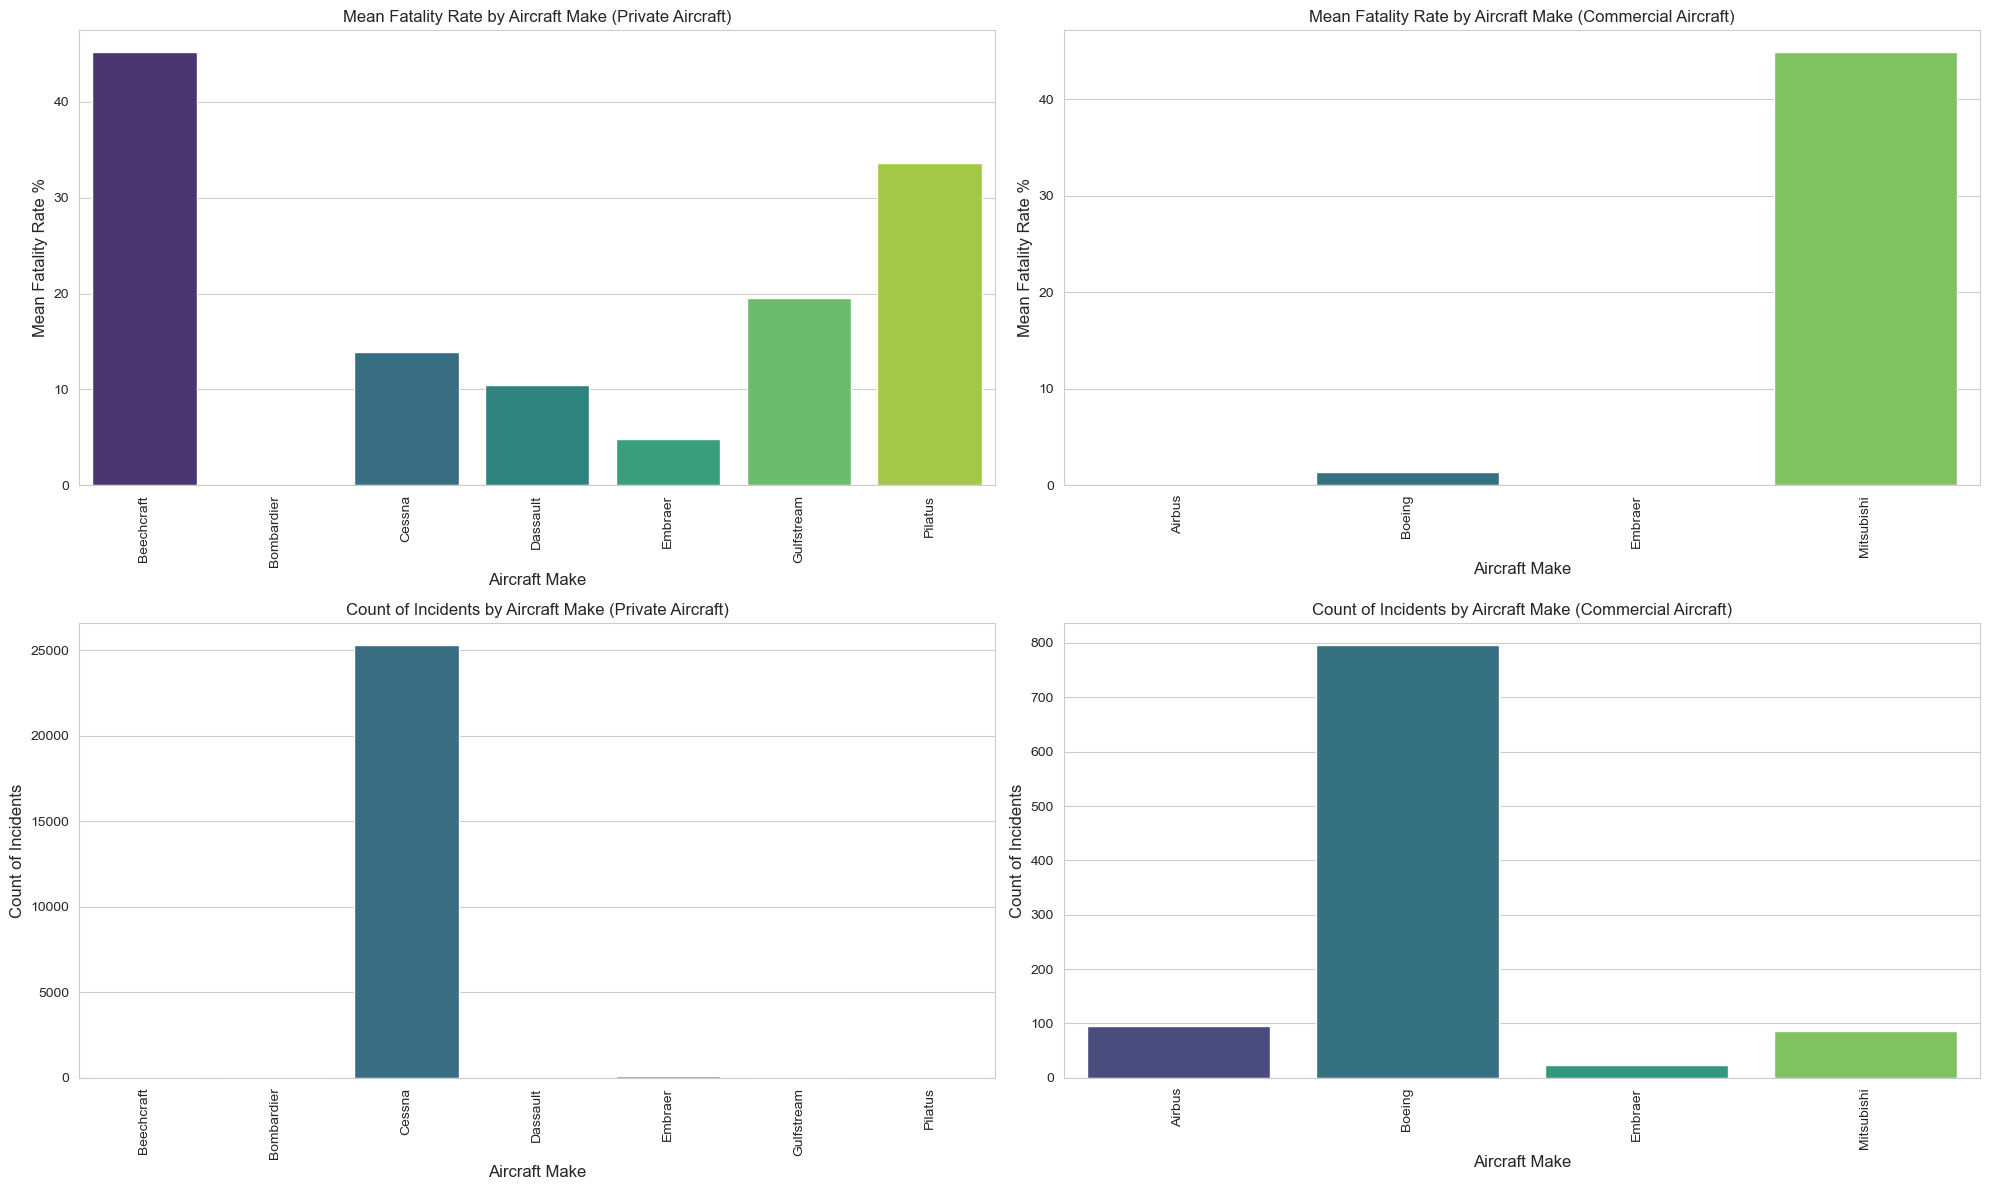

In [680]:
# Calculate the counts of each 'Make' and their corresponding mean fatality rates
private_make_counts = df_private['make.formatted'].value_counts().sort_index()
private_fatality_rates = df_private.groupby('Make')['Fatality.Rate'].mean().loc[private_make_counts.index]

commercial_make_counts = df_commercial['make.formatted'].value_counts().sort_index()
commercial_fatality_rates = df_commercial.groupby('make.formatted')['Fatality.Rate'].mean().loc[commercial_make_counts.index]

# Convert counts and rates to a DataFrame for plotting
private_make_df = pd.DataFrame({
    'Make': private_make_counts.index,
    'Counts': private_make_counts.values,
    'Fatality_Rate': private_fatality_rates.values
})

commercial_make_df = pd.DataFrame({
    'Make': commercial_make_counts.index,
    'Counts': commercial_make_counts.values,
    'Fatality_Rate': commercial_fatality_rates.values
})

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Create bar plot for mean fatality rate by aircraft make (private)
sns.barplot(x='Make', y='Fatality_Rate', data=private_make_df, ax=ax1, palette='viridis')
ax1.set_xlabel('Aircraft Make', size=12)
ax1.set_ylabel('Mean Fatality Rate %', size=12)
ax1.set_title('Mean Fatality Rate by Aircraft Make (Private Aircraft)')
ax1.tick_params(axis='x', rotation=90)

# Create bar plot for mean fatality rate by aircraft make (commercial)
sns.barplot(x='Make', y='Fatality_Rate', data=commercial_make_df, ax=ax2, palette='viridis')
ax2.set_xlabel('Aircraft Make', size=12)
ax2.set_ylabel('Mean Fatality Rate %', size=12)
ax2.set_title('Mean Fatality Rate by Aircraft Make (Commercial Aircraft)')
ax2.tick_params(axis='x', rotation=90)

# Create bar plot for count of incidents by aircraft make (private)
sns.barplot(x='Make', y='Counts', data=private_make_df, ax=ax3, palette='viridis')
ax3.set_xlabel('Aircraft Make', size=12)
ax3.set_ylabel('Count of Incidents', size=12)
ax3.set_title('Count of Incidents by Aircraft Make (Private Aircraft)')
ax3.tick_params(axis='x', rotation=90)

# Create bar plot for count of incidents by aircraft make (commercial)
sns.barplot(x='Make', y='Counts', data=commercial_make_df, ax=ax4, palette='viridis')
ax4.set_xlabel('Aircraft Make', size=12)
ax4.set_ylabel('Count of Incidents', size=12)
ax4.set_title('Count of Incidents by Aircraft Make (Commercial Aircraft)')
ax4.tick_params(axis='x', rotation=90)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()


## Cessna

Cessna makes up a huge portion of the private aircraft market. We can isolate the Cessna incidents and take a look at them independently.

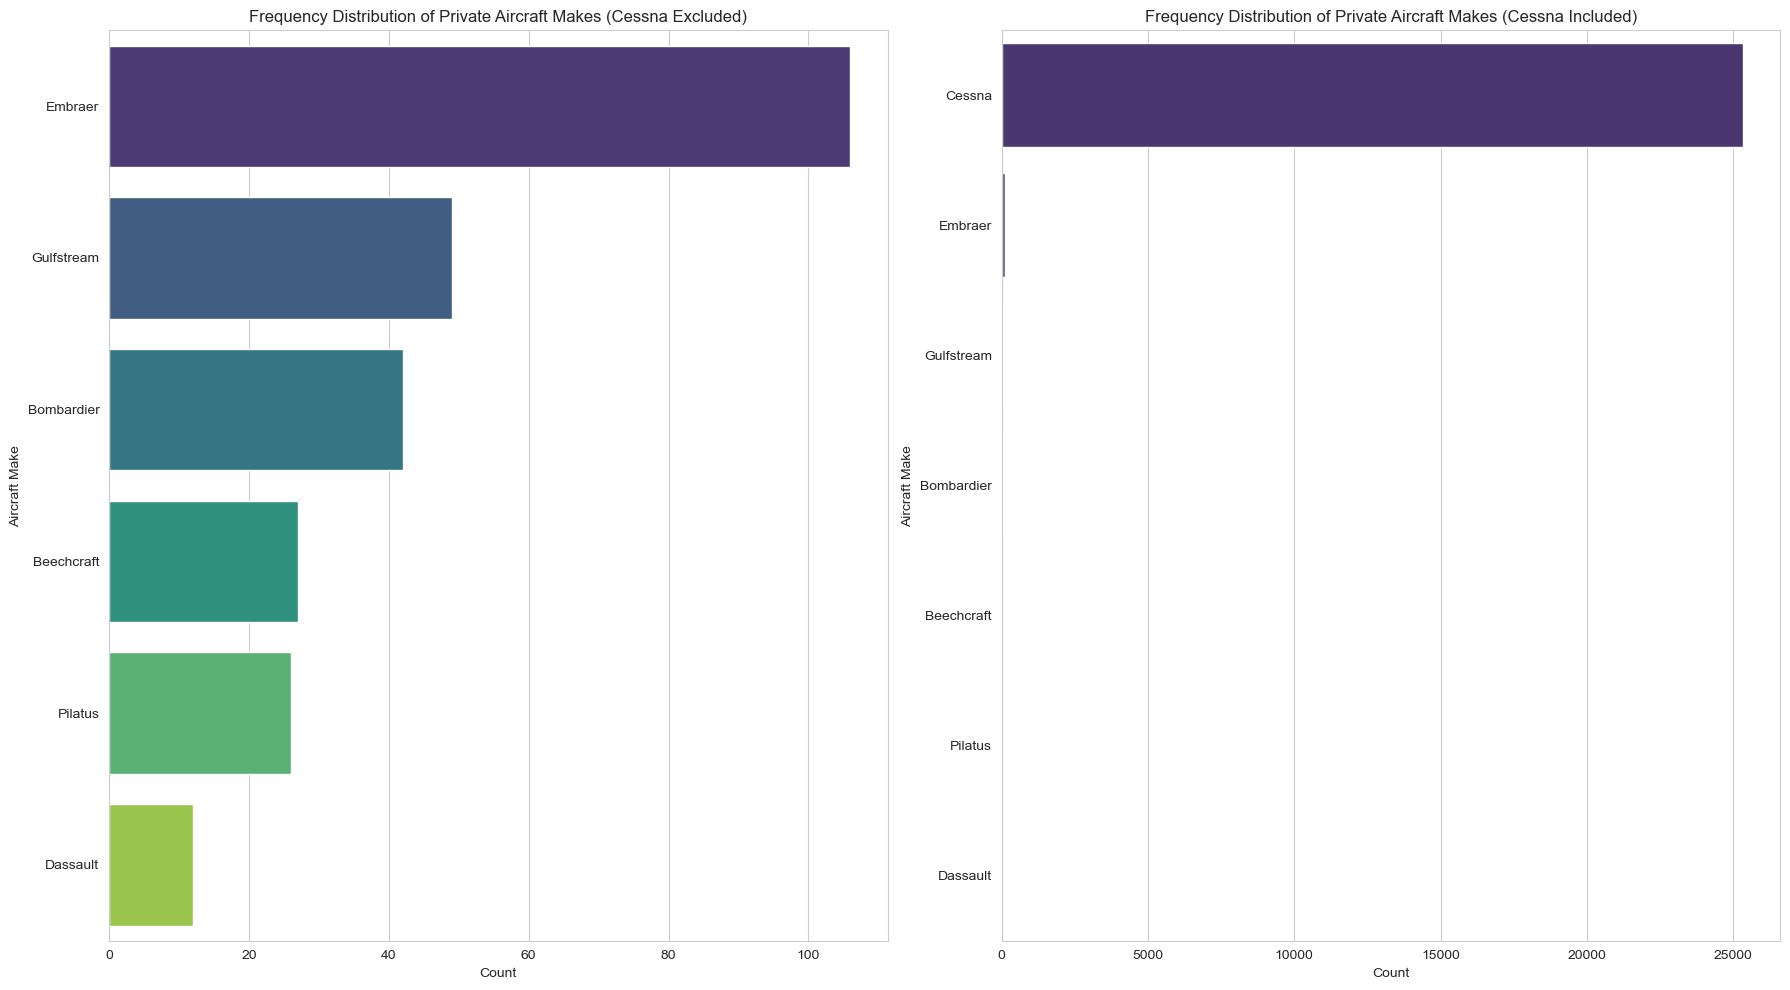

In [681]:
# Look at private makes with and without Cessna included

df_private_sans_cessna = df_private[df_private['Make'] != 'Cessna']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 10))
sns.countplot(y='Make', data=df_private_sans_cessna, order=df_private_sans_cessna['Make'].value_counts().index, palette='viridis', ax=ax1)
ax1.set_title('Frequency Distribution of Private Aircraft Makes (Cessna Excluded)')
ax1.set_xlabel('Count')
ax1.set_ylabel('Aircraft Make')

sns.countplot(y='Make', data = df_private, order=df_private['Make'].value_counts().index, palette='viridis', ax=ax2)
ax2.set_title('Frequency Distribution of Private Aircraft Makes (Cessna Included)')
ax2.set_xlabel('Count')
ax2.set_ylabel('Aircraft Make')

fig.tight_layout()

plt.show()


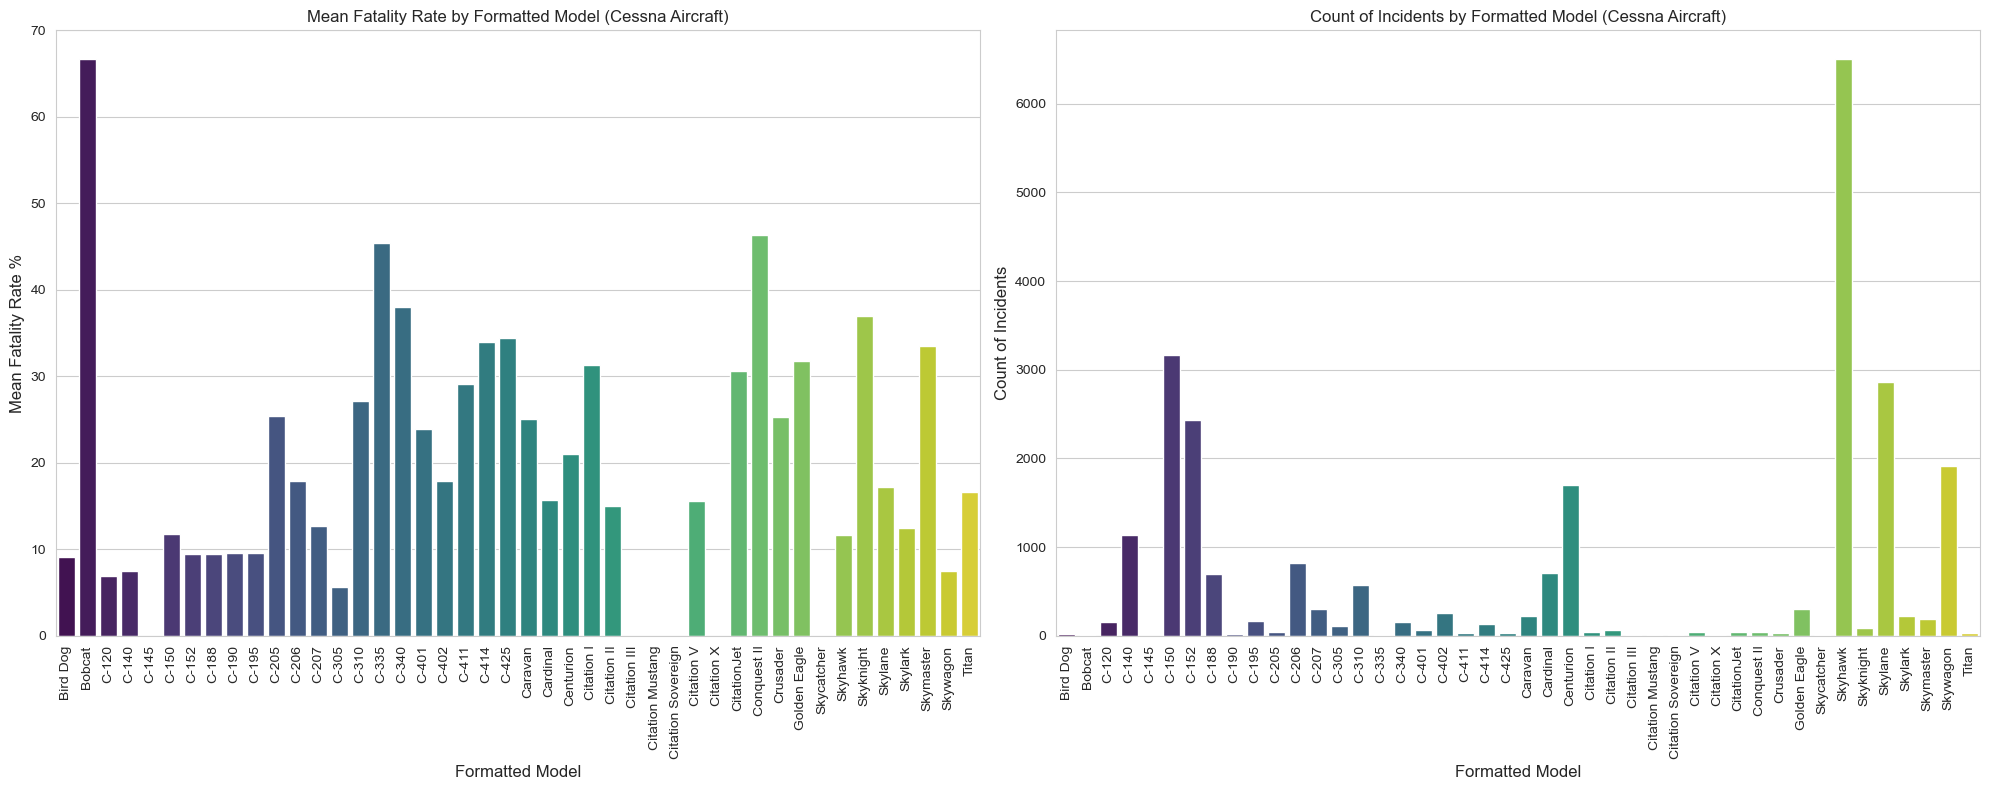

In [682]:
# Filter the DataFrame for rows where 'Make' is 'Cessna'
cessna_df = df_private[df_private['Make'] == 'Cessna']

# Calculate the mean fatality rate for each formatted model
cessna_fatality_rates = cessna_df.groupby('model.formatted')['Fatality.Rate'].mean().sort_index()

# Calculate the count of incidents for each formatted model
cessna_incident_counts = cessna_df['model.formatted'].value_counts().sort_index()

# Convert to DataFrames for plotting
cessna_fatality_df = cessna_fatality_rates.reset_index()
cessna_incident_df = cessna_incident_counts.reset_index()
cessna_incident_df.columns = ['model.formatted', 'Counts']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot mean fatality rate by formatted model for Cessna
sns.barplot(x='model.formatted', y='Fatality.Rate', data=cessna_fatality_df, ax=ax1, palette='viridis')
ax1.set_xlabel('Formatted Model', size=12)
ax1.set_ylabel('Mean Fatality Rate %', size=12)
ax1.set_title('Mean Fatality Rate by Formatted Model (Cessna Aircraft)')
ax1.tick_params(axis='x', rotation=90)

# Plot count of incidents by formatted model for Cessna
sns.barplot(x='model.formatted', y='Counts', data=cessna_incident_df, ax=ax2, palette='viridis')
ax2.set_xlabel('Formatted Model', size=12)
ax2.set_ylabel('Count of Incidents', size=12)
ax2.set_title('Count of Incidents by Formatted Model (Cessna Aircraft)')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()


## Non-Cessna

Now that we've taken a look at Cessna involved incidents, we can look at the remaining private aircraft data.

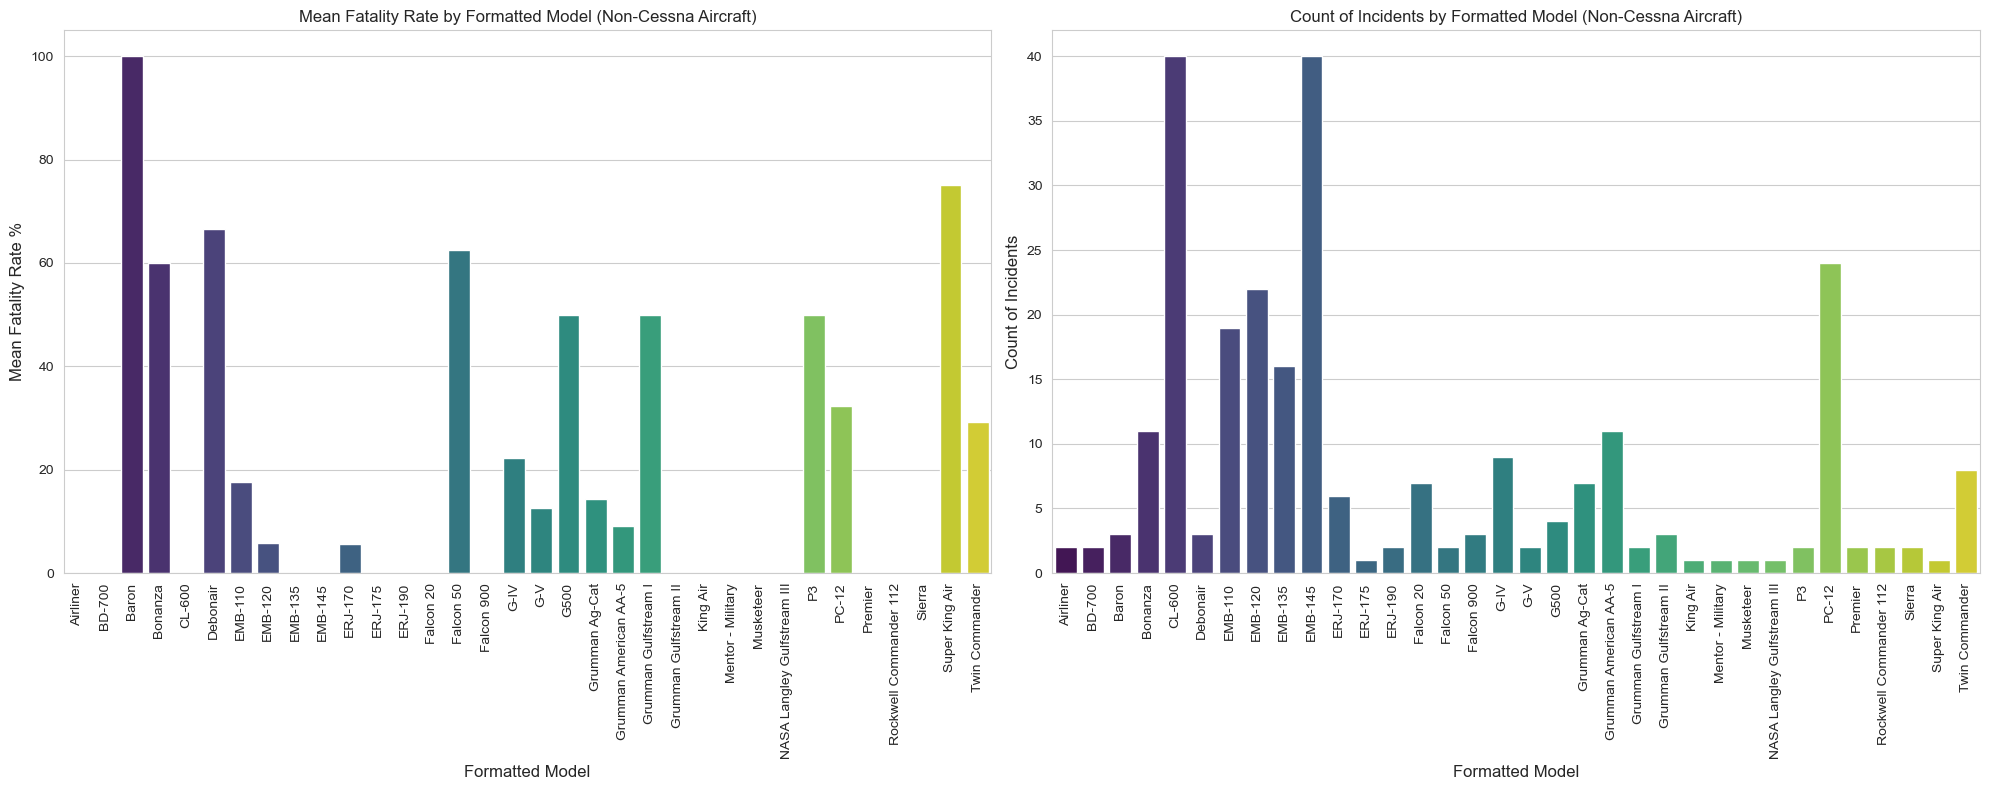

In [683]:
# Filter the DataFrame for rows where 'Make' is not 'Cessna'
non_cessna_df = df_private[df_private['Make'] != 'Cessna']

# Calculate the mean fatality rate for each formatted model
non_cessna_fatality_rates = non_cessna_df.groupby('model.formatted')['Fatality.Rate'].mean().sort_index()

# Calculate the count of incidents for each formatted model
non_cessna_incident_counts = non_cessna_df['model.formatted'].value_counts().sort_index()

# Convert to DataFrames for plotting
non_cessna_fatality_df = non_cessna_fatality_rates.reset_index()
non_cessna_incident_df = non_cessna_incident_counts.reset_index()
non_cessna_incident_df.columns = ['model.formatted', 'Counts']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot mean fatality rate by formatted model for Cessna
sns.barplot(x='model.formatted', y='Fatality.Rate', data=non_cessna_fatality_df, ax=ax1, palette='viridis')
ax1.set_xlabel('Formatted Model', size=12)
ax1.set_ylabel('Mean Fatality Rate %', size=12)
ax1.set_title('Mean Fatality Rate by Formatted Model (Non-Cessna Aircraft)')
ax1.tick_params(axis='x', rotation=90)

# Plot count of incidents by formatted model for Cessna
sns.barplot(x='model.formatted', y='Counts', data=non_cessna_incident_df, ax=ax2, palette='viridis')
ax2.set_xlabel('Formatted Model', size=12)
ax2.set_ylabel('Count of Incidents', size=12)
ax2.set_title('Count of Incidents by Formatted Model (Non-Cessna Aircraft)')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

## Commercial

Now we take a look at individual commercial aircraft models.

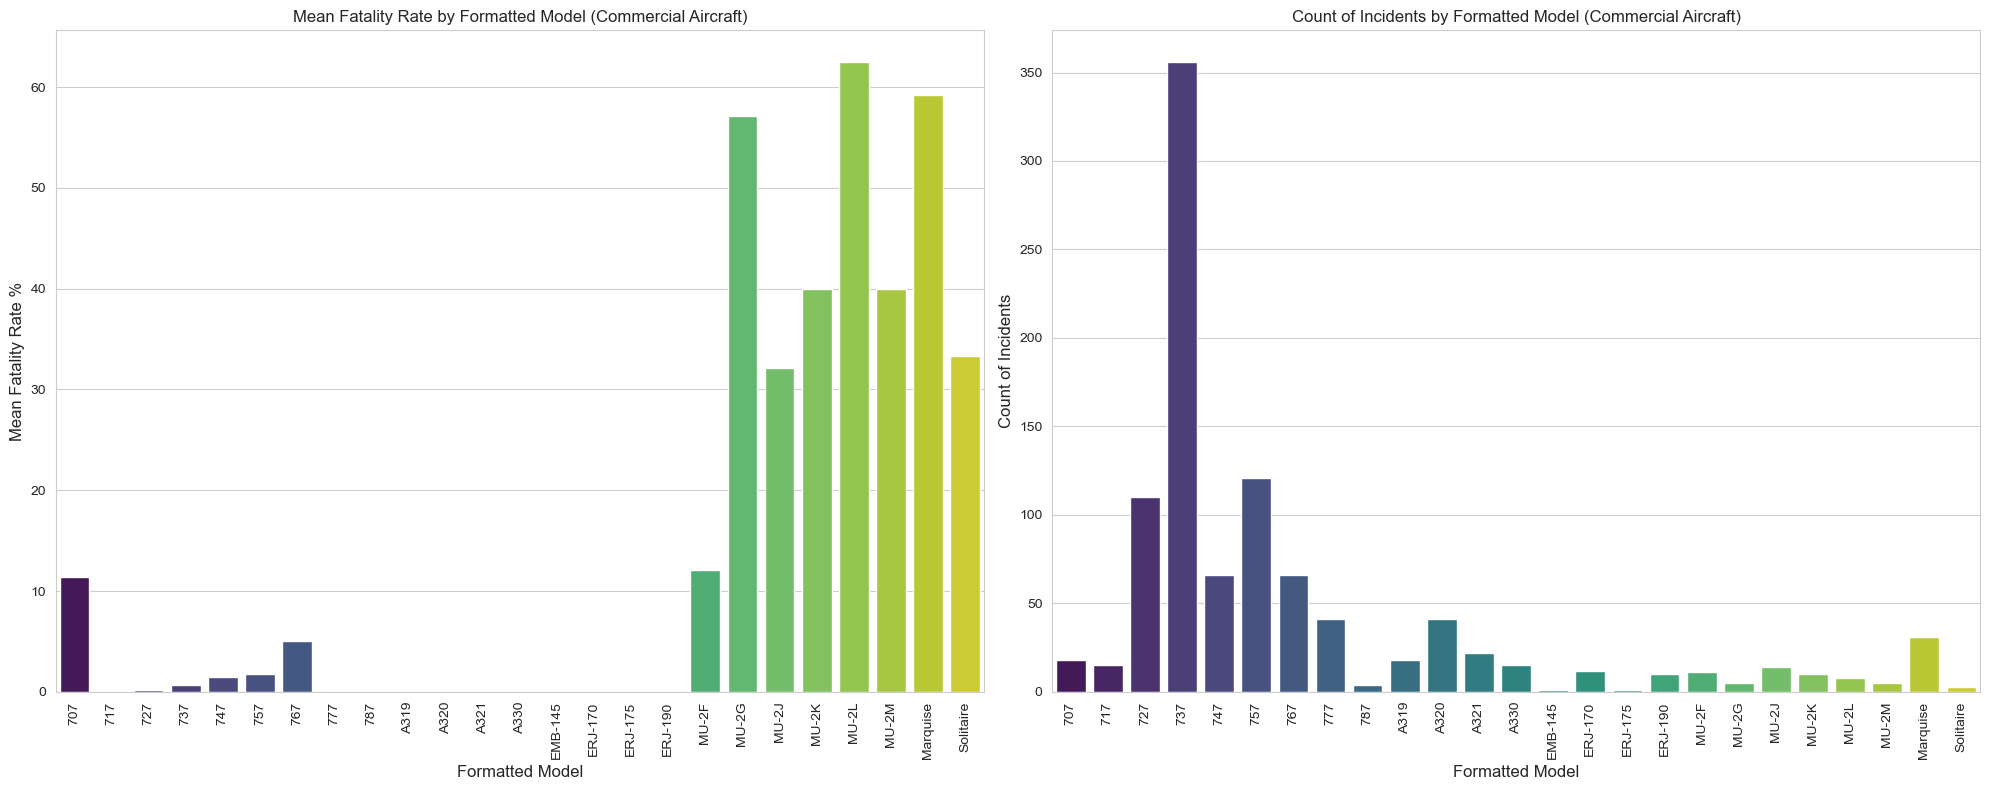

In [684]:
# Calculate the mean fatality rate for each formatted model
commercial_fatality_rates = df_commercial.groupby('model.formatted')['Fatality.Rate'].mean().sort_index()

# Calculate the count of incidents for each formatted model
commercial_incident_counts = df_commercial['model.formatted'].value_counts().sort_index()

# Convert to DataFrames for plotting
commercial_fatality_df = commercial_fatality_rates.reset_index()
commercial_incident_df = commercial_incident_counts.reset_index()
commercial_incident_df.columns = ['model.formatted', 'Counts']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot mean fatality rate by formatted model for Cessna
sns.barplot(x='model.formatted', y='Fatality.Rate', data=commercial_fatality_df, ax=ax1, palette='viridis')
ax1.set_xlabel('Formatted Model', size=12)
ax1.set_ylabel('Mean Fatality Rate %', size=12)
ax1.set_title('Mean Fatality Rate by Formatted Model (Commercial Aircraft)')
ax1.tick_params(axis='x', rotation=90)

# Plot count of incidents by formatted model for Cessna
sns.barplot(x='model.formatted', y='Counts', data=commercial_incident_df, ax=ax2, palette='viridis')
ax2.set_xlabel('Formatted Model', size=12)
ax2.set_ylabel('Count of Incidents', size=12)
ax2.set_title('Count of Incidents by Formatted Model (Commercial Aircraft)')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

## Helicopters

And finally we'll dive into the helicopter model data.

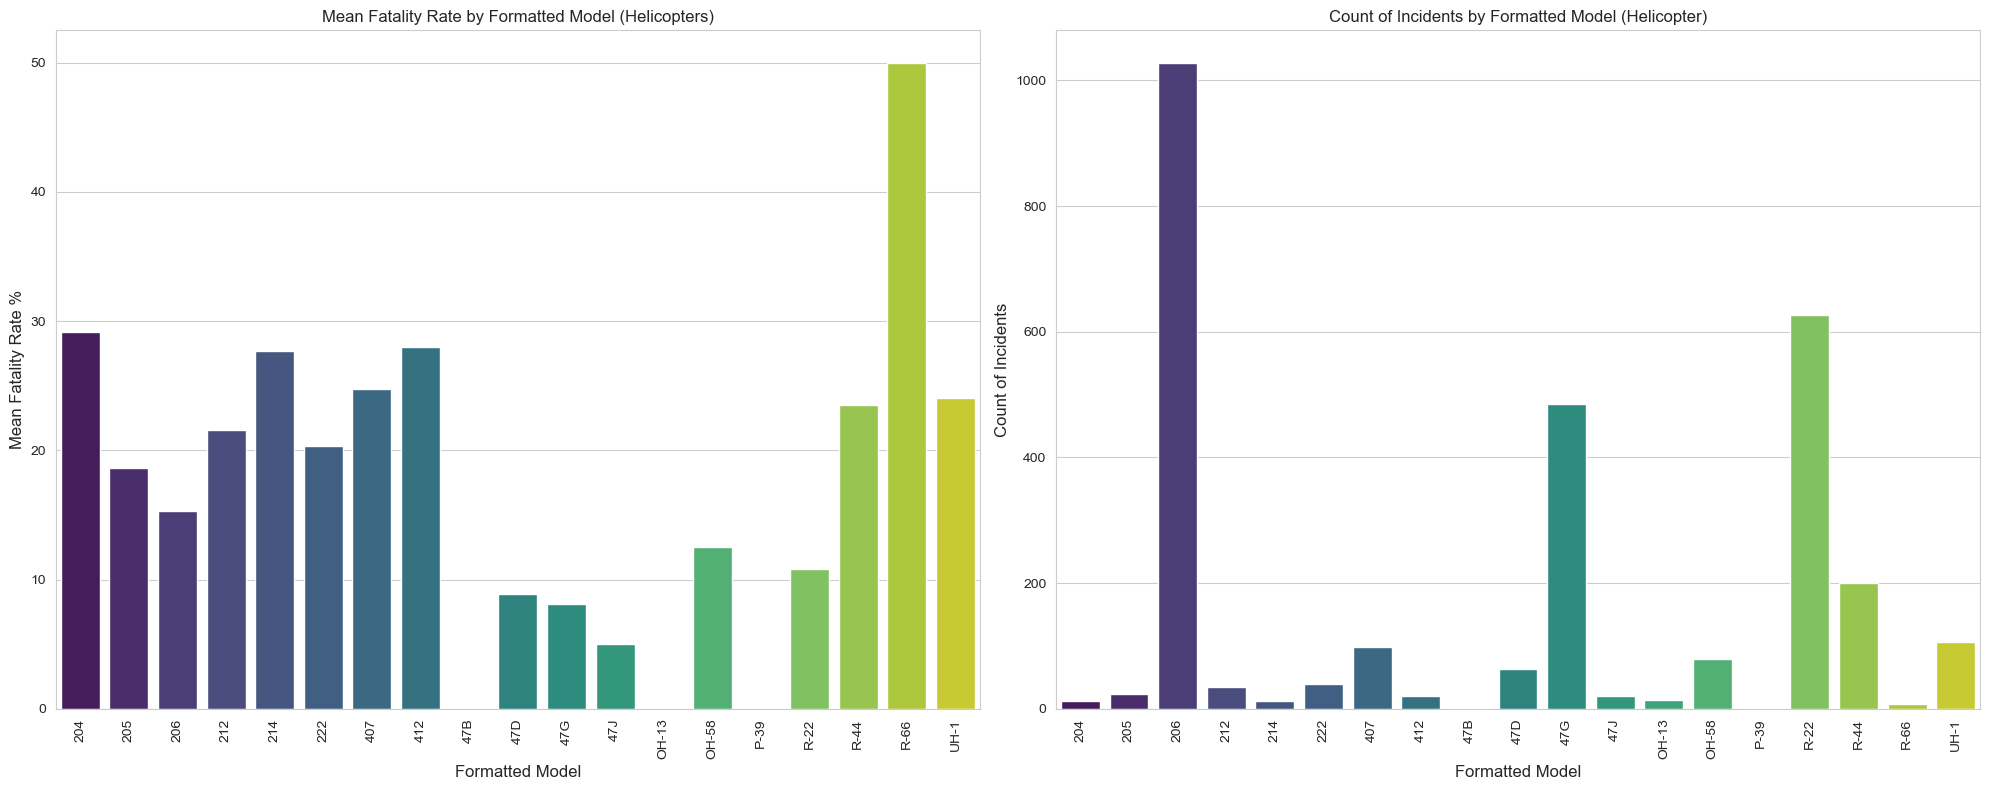

In [685]:
# Calculate the mean fatality rate for each formatted model
helicopter_fatality_rates = df_helicopter.groupby('model.formatted')['Fatality.Rate'].mean().sort_index()

# Calculate the count of incidents for each formatted model
helicopter_incident_counts = df_helicopter['model.formatted'].value_counts().sort_index()

# Convert to DataFrames for plotting
helicopter_fatality_df = helicopter_fatality_rates.reset_index()
helicopter_incident_df = helicopter_incident_counts.reset_index()
helicopter_incident_df.columns = ['model.formatted', 'Counts']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot mean fatality rate by formatted model for Cessna
sns.barplot(x='model.formatted', y='Fatality.Rate', data=helicopter_fatality_df, ax=ax1, palette='viridis')
ax1.set_xlabel('Formatted Model', size=12)
ax1.set_ylabel('Mean Fatality Rate %', size=12)
ax1.set_title('Mean Fatality Rate by Formatted Model (Helicopters)')
ax1.tick_params(axis='x', rotation=90)

# Plot count of incidents by formatted model for Cessna
sns.barplot(x='model.formatted', y='Counts', data=helicopter_incident_df, ax=ax2, palette='viridis')
ax2.set_xlabel('Formatted Model', size=12)
ax2.set_ylabel('Count of Incidents', size=12)
ax2.set_title('Count of Incidents by Formatted Model (Helicopter)')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

# Conclusion Notes

- The number of fatalities ranges from 0 to 228 with an average of 0.33 fatalities per incident.
- The percentage of fatalities amongst total passengers per incident is 13.76% on average.
- There is a moderately positive correlation between both `Total.Uninjured` and `Total.Pax` with `Number.of.Engines`:
    - This is likely related to larger aircraft. The bigger the aircraft, the more people it can carry, and the more engines it needs to do so.
    - Interestingly, in private aircraft, fewer engines correlate to a higher survival rate, whereas the opposite is true for commercial aircraft.
- There is a weakly negative correlation between `Damage.Encoded` and `Total.Uninjured`:
    - This makes sense, as lower damage results in more uninjured passengers.
- Private aircraft and helicopters have a more frequent instance of 'substantial' damage, whereas commercial aircraft have the highest instance of 'unknown' damage.
- Turboprop engine types have the highest fatality rates in both private and commercial aircraft. Turboshaft engines account for the highest fatality rate in helicopters.
- Cessna has one of the lower fatality rates for private aircraft but has the highest incident rate (Cessna is the most popular manufacturer in the world by units produced).
- **Cessna**:
    - The Skyhawk, C-150, Skylane, Skywagon, and Centurion all have over 1000 data points each, with the Skyhawk exceeding 6500 data points, all maintaining a < 20% fatality rate (except for the Centurion model with a 21% mean fatality rate).
    - Specific fatality rates for notable models:
        - Skyhawk: 11.65% fatality rate over 6503 incidents.
        - C-150: 11.72% fatality rate over 3162 incidents.
        - Skylane: 17.15% fatality rate over 2858 incidents.
        - Skywagon: 7.49% fatality rate over 1912 incidents.
        - Centurion: 21.00% fatality rate over 1703 incidents.
- **Non-Cessna Private Craft**:
    - The remaining private aircraft have far fewer incidents/data points, making it more difficult to provide good recommendations. However:
        - The Bombardier Challenger 600 (CL-600) has 40 incidents in the dataset with a mean fatality rate of 0%.
        - The Embraer EMB-145 has fewer incidents but a mean fatality rate of 0%.
        - The Pilatus PC-12 has 24 incidents in the dataset with a mean fatality rate of 32.29%.
- **Commercial**:
    - The Boeing 737 has the largest amount of data points with a mean fatality rate of 0.71%.
    - All other Boeing models have a mean fatality rate below 2%, except for the 707 and 767:
        - 707: 11.40% fatality rate over 18 incidents.
        - 767: 5.00% fatality rate over 66 incidents.
    - All Airbus models and Embraer commercial craft have a mean fatality rate of 0%.
    - Mitsubishi models show high fatality rates:
        - MU-2F: 12.12% fatality rate over 11 incidents.
        - Marquise: 59.22% fatality rate over 31 incidents.
        - Solitaire: 33.33% fatality rate over 3 incidents.
        - Other models such as MU-2G, MU-2J, MU-2K, MU-2L, and MU-2M have varying fatality rates from 32.14% to 62.50%.
- **Helicopter**:
    - The Bell 206, Robinson R-22, and Robinson R-44 all have over 100 incidents in the dataset and all maintain a < 20% mean fatality rate:
        - Bell 206: 15.32% fatality rate over 1028 incidents.
        - Robinson R-22: 10.79% fatality rate over 626 incidents.
        - Robinson R-44: 23.54% fatality rate over 200 incidents.

# Recommendations

Based on the analysis, here are some recommendations for safer aircraft choices:

### Private Aircraft

- Single-engine aircraft tend to have the lowest average fatality rates.
- Exercise caution with turboprop engines, which have the highest fatality rates. Turbofan and reciprocating engines have nearly tied for the lowest fatality rates.
- Generally, more passengers equate to lower fatality rates.

### Commercial Aircraft

- Dual-engine aircraft have the highest fatality rates but still lower than all private aircraft engine counts.
- Turboprop engines have the highest fatality rates by a significant margin, while turbofan and turbojet engines have the lowest fatality rates.
- Higher passenger counts generally correlate with lower fatality rates.

### Helicopters

- Turboshaft engine types have the highest fatality rates, and reciprocating engines have the lowest, though both have relatively low rates.
- There is no apparent correlation between passenger count and fatality rate, which makes sense since helicopters aren't typically capable of carrying large numbers of people.

# Additional Considerations

- The recommendations can become more accurate and helpful upon further review from the relevant stakeholders within the business. Important factors to consider include:
    - Are we focusing on passenger aircraft, cargo aircraft, or both?
    - Are we interested in larger long-haul flights or shorter hops?
    - Are helicopters of interest?
    - Are we looking for business jets to carry C-suite executives to meetings?
    - Do we need smaller short-runway capable aircraft to carry medications or other supplies to remote locations?


In [686]:
df_clean.to_excel('data/cleaned_data.xlsx', index=False)